In [23]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

Felten et al. (2021) developed the AI Occupational Exposure (AIOE) measure to evaluate how AI capabilities align with occupational tasks. They began with ten AI applications from the Electronic Frontier Foundation’s AI Progress Measurement and linked them to 52 occupational abilities from O*NET using crowd-sourced relevance ratings, which measure how applicable each AI application is to each ability. The summed relevance ratings for each ability give the ability-level exposure, denoted as $A_j$, where $j$ indexes the 52 abilities.


Each job in O*NET also has ratings for how important and prevalent an ability is, denoted by $I_{jk}$ and $L_{jk}$ for job $k$. Since a job is essentially a weighted bundle of abilities, Felten et al. aggregate across them using $\sum_{j=1}^{52} L_{jk} \cdot I_{jk}$. To incorporate AI, they multiply by $A_j$ to capture how exposed each ability is to AI before summing across all abilities. The AIOE for some job $k$ is then:  

$$
\text{AIOE}_k = \frac{\sum_{j=1}^{52} A_j \cdot L_{jk} \cdot I_{jk}}{\sum_{j=1}^{52} L_{jk} \cdot I_{jk}}.
$$


# I. Retrieving Ability-Level AI Exposure ($A_j$)

In [24]:
# Open the data and get the sheet for the ability-level AI Exposure
filename = 'data/AIOE_DataAppendix.xlsx'
ai_exposure = pd.read_excel(filename, sheet_name=5, index_col=0)

# Rename one index from Visual Color Determination to Visual Color Discrimination
ai_exposure.rename(index={'Visual Color Determination' : 'Visual Color Discrimination'}, inplace=True)

# Create a function that takes in the abilities and gives the exposure to AI 
overall_ai_exposure = dict(zip(ai_exposure.index, ai_exposure['Ability-Level AI Exposure']))

# Place it as a table
# data = ai_exposure.sort_values(by='Ability-Level AI Exposure', ascending=False)

# II. Retrieving the Importance ($I_{jk}$) and Prevalence ($L_{jk}$) of an Ability to Each Job

In [39]:
# Get the data dictionary so that we can name the abilities and not deal with codes
filename = 'data/Content Model Reference.xlsx'
data_dict_df = pd.read_excel(filename)
data_dict = dict(zip(data_dict_df['Element ID'], data_dict_df['Element Name']))

# Open the abilities database
conn = sqlite3.connect('data/abilities.db')
abilities_df = pd.read_sql('SELECT * FROM abilities', conn)
abilities_df['SOC'] = abilities_df['onetsoc_code'].apply(lambda x : x[:7])
abilities_df['ability'] = abilities_df['element_id'].apply(lambda x : data_dict[x])

# Make sure date is in datetime format
abilities_df['date_updated'] = pd.to_datetime(abilities_df['date_updated'])

# Keep the latest date for each SOC and ability, but preserve first-seen order
abilities_df = (
    abilities_df
    .sort_values('date_updated')  # oldest to newest
    .drop_duplicates(
        subset=['SOC', 'ability', 'scale_id'], 
        keep='last'                # keep the most recent
    )
    .sort_index()  # restore original row order formatting
)

In [40]:
# Create a nested dictionary with the structure:
# {SOC_code: {ability: {scale: value}}}
soc_dict = {}

for _, row in abilities_df.iterrows():
    soc = row['SOC']
    ability = row['ability']
    scale = row['scale_id']
    score = row['data_value']

    # make sure structure exists
    if soc not in soc_dict:
        soc_dict[soc] = {}
    if ability not in soc_dict[soc]:
        soc_dict[soc][ability] = {}

    # assign score
    soc_dict[soc][ability][scale] = score

    # Add the AI score. We can do this repeatedly because it won't rlly change.
    scale='A'
    soc_dict[soc][ability][scale] = overall_ai_exposure[ability]

# III. Computing the AIOE Score for each SOC Code

In [41]:
# Create a function that takes in the SOC code and outputs the AIOE score
soc_aioe = {}
for soc, abilities in soc_dict.items():
    weight = 0
    ai_weight = 0
    for ability in abilities.values():
        importance = ability['IM']
        ai = ability['A']
        prevalence = ability['LV']

        weight += importance * prevalence
        ai_weight += ai * importance * prevalence
    soc_aioe[soc] = ai_weight/weight


abilities_df['AIOE'] = abilities_df['SOC'].apply(lambda x : soc_aioe[x])

# Compute median and IQR
median = abilities_df['AIOE'].mean()
std = abilities_df['AIOE'].std()
abilities_df['AIOE'] = (abilities_df['AIOE'] - median) / std

# Update the SOC → AIOE mapping
soc_aioe = dict(zip(abilities_df['SOC'], abilities_df['AIOE']))

# Create a dataframe for the SOC to AIOE 
aioe_wadhwani = pd.DataFrame({'SOC': abilities_df['SOC'], 
                              'AIOE': abilities_df['AIOE']}
                              )

aioe_wadhwani.drop_duplicates(inplace=True)

As a validation step, we must ensure that the histogram provided by Felten et al. aligns with the distribution generated from our calculations. While some differences in AIOE scores are expected due to updates in O\*NET’s prevalence and importance ratings, the overall shape of the distributions should remain consistent. Below, we present both the histogram from Felten et al. (a) and our corresponding distribution (b) of AIOE scores. Because the two figures present a similar shape, we can be fairly certain that we have followed accurately the methodology of Felten et al.

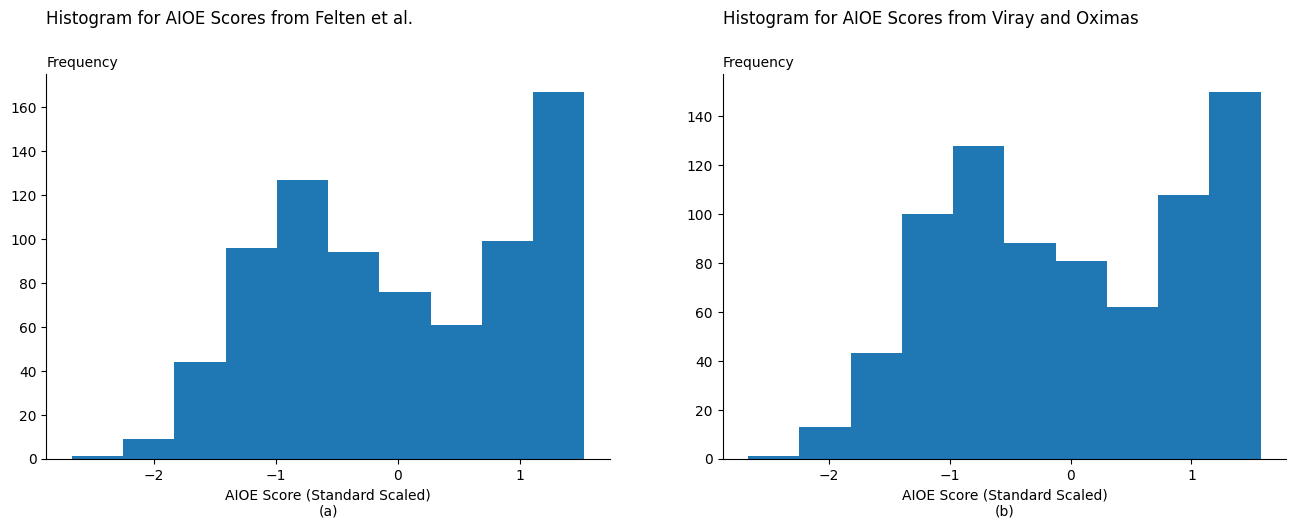

In [42]:
# Get the aioe scores of felten
filename = 'data/AIOE_DataAppendix.xlsx'
aioe_felten = pd.read_excel(filename, sheet_name=1, index_col=0)['AIOE']

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Plot Felten
ax[0].hist(aioe_felten)
ax[0].set_xlabel('AIOE Score (Standard Scaled)\n(a)')
ax[0].set_title('Histogram for AIOE Scores from Felten et al.\n\n', loc='left')

# Plot Wadhwani
ax[1].hist(aioe_wadhwani['AIOE'])
ax[1].set_xlabel('AIOE Score (Standard Scaled)\n(b)')
ax[1].set_title('Histogram for AIOE Scores from Viray and Oximas\n\n', loc='left')

for axi in ax:
    axi.spines['top'].set_visible(False)
    axi.spines['right'].set_visible(False)
    axi.set_ylabel('Frequency', rotation=0, ha='left')
    axi.yaxis.set_label_coords(0, 1.01)

# IV. Mapping Philippine Jobs to their AIOE Scores

From the previous step, the mapping from the ISCO codes to the SOC codes had a flaw since some are legacy SOC codes, which need to be updated. This issue arose from earlier iterations when we identified codes that did not map to the O*NET database. Each unmatched code was then manually reviewed to determine whether a corresponding updated SOC code exists.


In [43]:
filename = '../1_crosswalk_mca_soc/mca_soc.csv'
mca_df = pd.read_csv(filename)

old_to_new = {
    "15-1151": "15-1232",
    "19-4093": "19-4071",
    "15-1199": "15-1299",
    "15-1141": "15-1242",
    "51-9122": "51-9124",
    "15-1134": "15-1254",
    "53-7032": "47-5022",
    "31-1014": "31-1131",
    "25-9011": "25-9011",
    "43-9011": "15-1299",
    "29-1069": "29-1229",
    "53-7033": "47-5044",
    "29-9011": "19-5011",
    "15-1121": "15-1211",
    "15-1152": "15-1231",
    "15-1142": "15-1244",
    "19-4091": "19-4042",
    "47-5031": "47-5032",
    "45-3021": "45-3031",
    "51-4012": "51-9162"
}

mca_df['SOC'] = mca_df['SOC'].replace(old_to_new)

# Rename Job Sectors that only differ because of Capitalization 
sector_standardization = {
    'Arts, entertainment and recreation': 'Arts, Entertainment and Recreation',
    'Professional, Scientific And Technical Activities': 'Professional, Scientific and Technical Activities',
    'professional, scientific and technical activities': 'Professional, Scientific and Technical Activities',
}

mca_df['Job Sector'] = mca_df['Job Sector'].replace(sector_standardization)


Most jobs in the MCA list can be mapped directly to their corresponding AIOE values. However, about 16.92% have missing scores, likely because O*NET lacks complete ability, importance, or prevalence data for these SOC codes. We impute these missing values using the median AIOE of their major-minor group. For example, the Academic Researcher (SOC 19-1099) is assigned the median AIOE of all jobs with SOC codes starting with 19. The median is used because the AIOE distribution is left-skewed, making it more robust than the mean.


In [44]:
mca_df['AIOE'] = mca_df['SOC'].apply(lambda x : soc_aioe.get(x.strip(), np.nan))
mca_df.isnull().sum() / mca_df.shape[0]

Job Title                                                 0.000000
Job Sector                                                0.000000
Job Subsector                                             0.000000
Educational Pathway                                       0.000000
HEI with PRC (Professional Regulation Commission) Exam    0.000000
Some HEI                                                  0.000000
PSOC                                                      0.000000
ISCO                                                      0.000000
SOC                                                       0.000000
AIOE                                                      0.169176
dtype: float64

In [45]:
# Get the first two codes (which are called the major and minor group)
mca_df['major_minor'] = mca_df['SOC'].str[:2]

# Impute based on the median
mca_df['AIOE'] = mca_df['AIOE'].fillna(
    mca_df.groupby('major_minor')['AIOE'].transform('median')
)

# Output the mca with the AIOE scores
mca_df.to_csv('soc_aioe.csv', index=False)